# MCMC with library emcee
---

### MCMC part prepared with student Piotr Łojko from University of Wrocław

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

### State the problem

**Inferring a parameters of 2D Gaussian model**:
* parameters, $\theta \equiv \Big[\mu_x,\mu_y,\sigma_x,\sigma_y,\rho\Big]$,
* data, $\mathcal{D} \equiv \{\vec{x}\}_N$, where $\vec{x} = (x,y)$,
* sampling density, $p(\mathcal{D}|\theta) = \prod_{i=1}^N N(\vec{x}|\theta)$,
* prior, $p(\theta) = U(\mathcal{R}^5)$,
* posterior, $p(\theta | \mathcal{D}) \propto p(\mathcal{D}|\theta)p(\theta)=\prod_{i=1}^N N(\vec{x}_i|\theta)$
* logarithm-posterior, $\ln( p(\theta | \mathcal{D})) = \sum_{i=1}^N \ln(N(\vec{x}_i|\theta)) + \mathrm{constant}$

In the logarithm-posterior the $\mathrm{constant}$ can absorp all sum components not dependent on the $\theta$.

$$
N(\vec{x}|\theta) = \frac{1}{2\pi\sigma_x\sigma_y\sqrt{1-\rho^2}} \exp\Big[-\frac{1}{2(1-\rho^2)}\Big( \frac{(x - \mu_x)^2}{\sigma_x^2} -  \frac{2\rho(x - \mu_x)(y - \mu_y)}{\sigma_x\sigma_y} + \frac{(y - \mu_y)^2}{\sigma_y^2} \Big)\Big]
$$

$$
\ln (p(\theta | \mathcal{D})) = -N\ln\big(\sigma_x\sigma_y\sqrt{1-\rho^2}\big) - \frac{1}{2(1-\rho^2)}\Big( \frac{\sum_{i=1}^N(x_i - \mu_x)^2}{\sigma_x^2} -  \frac{2\rho\sum_{i=1}^N(x_i - \mu_x)(y_i - \mu_y)}{\sigma_x\sigma_y} + \frac{\sum_{i=1}^N(y_i - \mu_y)^2}{\sigma_y^2} \Big) + \textrm{constant}
$$

In [2]:
def log_prior(theta):
    mu_x, mu_y, sigma_x, sigma_y, rho = theta
    if 0.0 <= sigma_x < 10. \
            and 0.0 <= sigma_y < 10.0 \
            and -1.0 < rho < 1.0 \
            and -100.0<mu_x<100.0 \
            and -100.0<mu_y<100.0:
        return 0.0
    return -np.inf
    
def log_prob(theta, data):
    x = data[:,0]
    y = data[:,1]
    N = x.shape[0]
    mu_x, mu_y, sigma_x, sigma_y, rho = theta
    one_minus_rho_2 = 1 - rho**2
    log_prior_val = log_prior(theta)
    if one_minus_rho_2 <= 0.0 or log_prior_val == -np.inf:
        return -np.inf
    else:
        xx = np.sum((x - mu_x)**2)/sigma_x**2
        xy = - 2*rho*np.sum((x - mu_x)*(y - mu_y))/(sigma_x*sigma_y)
        yy = np.sum((y - mu_y)**2)/sigma_y**2
        z = xx + xy + yy
        return -N*np.log(sigma_x*sigma_y*np.sqrt(one_minus_rho_2)) - z/(2*one_minus_rho_2)

### Analytical solution

https://stats.stackexchange.com/questions/50844/estimating-the-covariance-posterior-distribution-of-a-multivariate-gaussian

-1.9091385548646427 -6.379902735130915


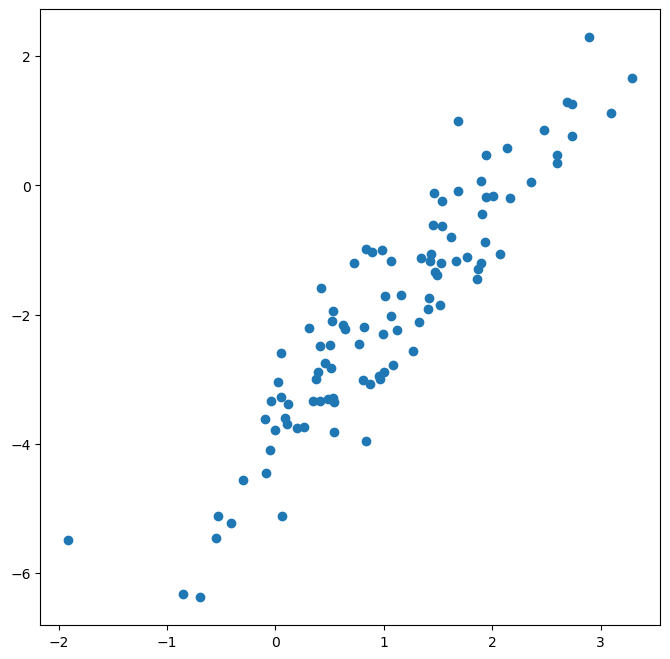

In [3]:
# Number of simulated datapoints
N = 100

# Define parameters which we will be infering
mu_x = 1
mu_y = -2
sigma_x = 1
sigma_y = 2
rho = 0.9

theta = (mu_x, mu_y, sigma_x, sigma_y, rho)
ndim = len(theta)

# Generate data

rng = np.random.default_rng(seed=42)

mean = (mu_x,mu_y)
cov = [[sigma_x**2,rho*sigma_x*sigma_y],
       [rho*sigma_x*sigma_y, sigma_y**2]]
data = rng.multivariate_normal(mean, cov, size=N)

# Plot samples
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(data[:,0],data[:,1])

print(data[:,0].min(),data[:,1].min())

In [4]:
# check the log-likelihood value
log_prob(theta, data)

-63.76255031855064

### Use MCMC sampler from emcee to sample defined posterior

In [5]:
# Number of walkers
nwalkers = 32

# Initialize walkers positions
rng = np.random.default_rng(seed=42)
p0 = rng.uniform(low=0.0, high=1.0, size=(nwalkers, ndim))
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[data,],vectorize=False)

In [6]:
# Burn in phase
state = sampler.run_mcmc(p0, 200, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 735.09it/s]


Walkers chains in the burn-in phase:

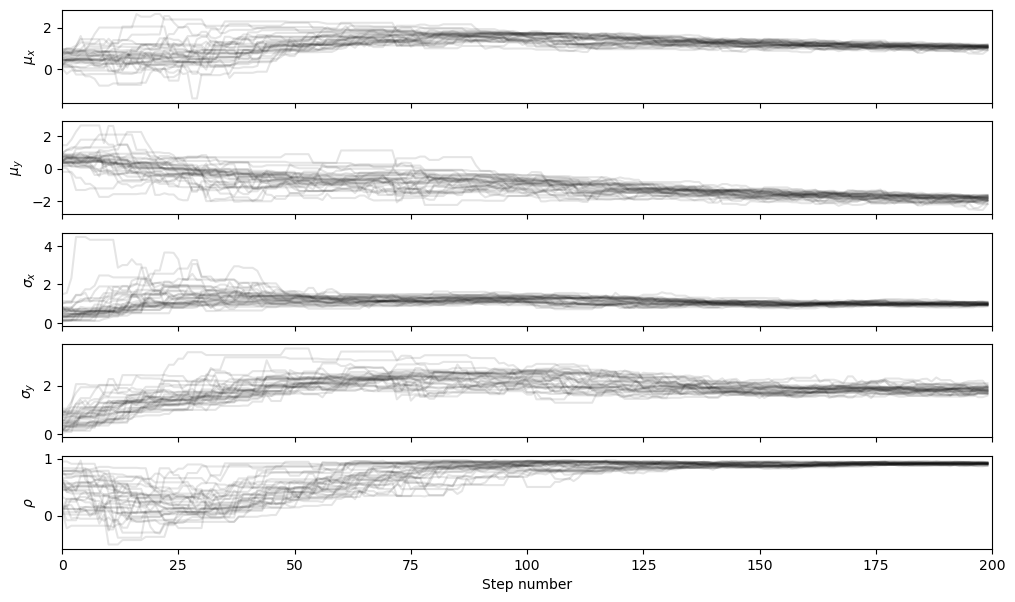

In [7]:
fig, axes = plt.subplots(5, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\mu_x$", r"$\mu_y$", r"$\sigma_x$", r"$\sigma_y$",r"$\rho$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number");

In [8]:
sampler.reset()

In [9]:
sampler.run_mcmc(state, 5000, progress=True)
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time: {np.mean(sampler.get_autocorr_time()):.3f} steps")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 836.47it/s]


Mean acceptance fraction: 0.546
Mean autocorrelation time: 52.966 steps


## Plot the walker chains

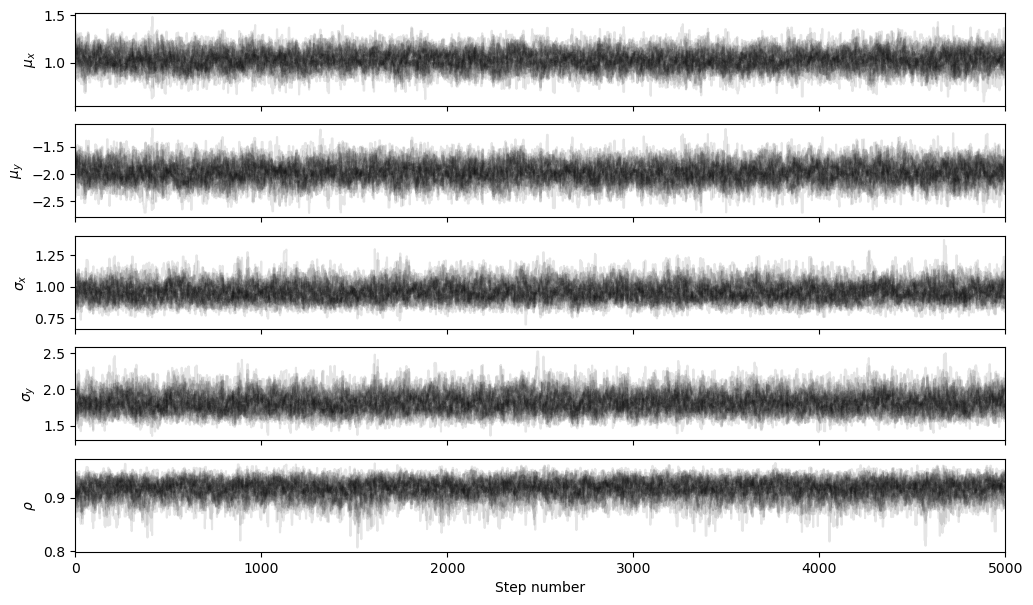

In [10]:
fig, axes = plt.subplots(5, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\mu_x$", r"$\mu_y$", r"$\sigma_x$", r"$\sigma_y$",r"$\rho$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number");

### Thin and flatten chains

In [11]:
# Mean autocorrelation time: 57.387 steps so I chosen thinning equal 60
flat_samples = sampler.get_chain(discard=0, thin=60, flat=True) 
print(flat_samples.shape)

(2656, 5)


### Prepare a corner plots

In [12]:
flat_samples.shape

(2656, 5)

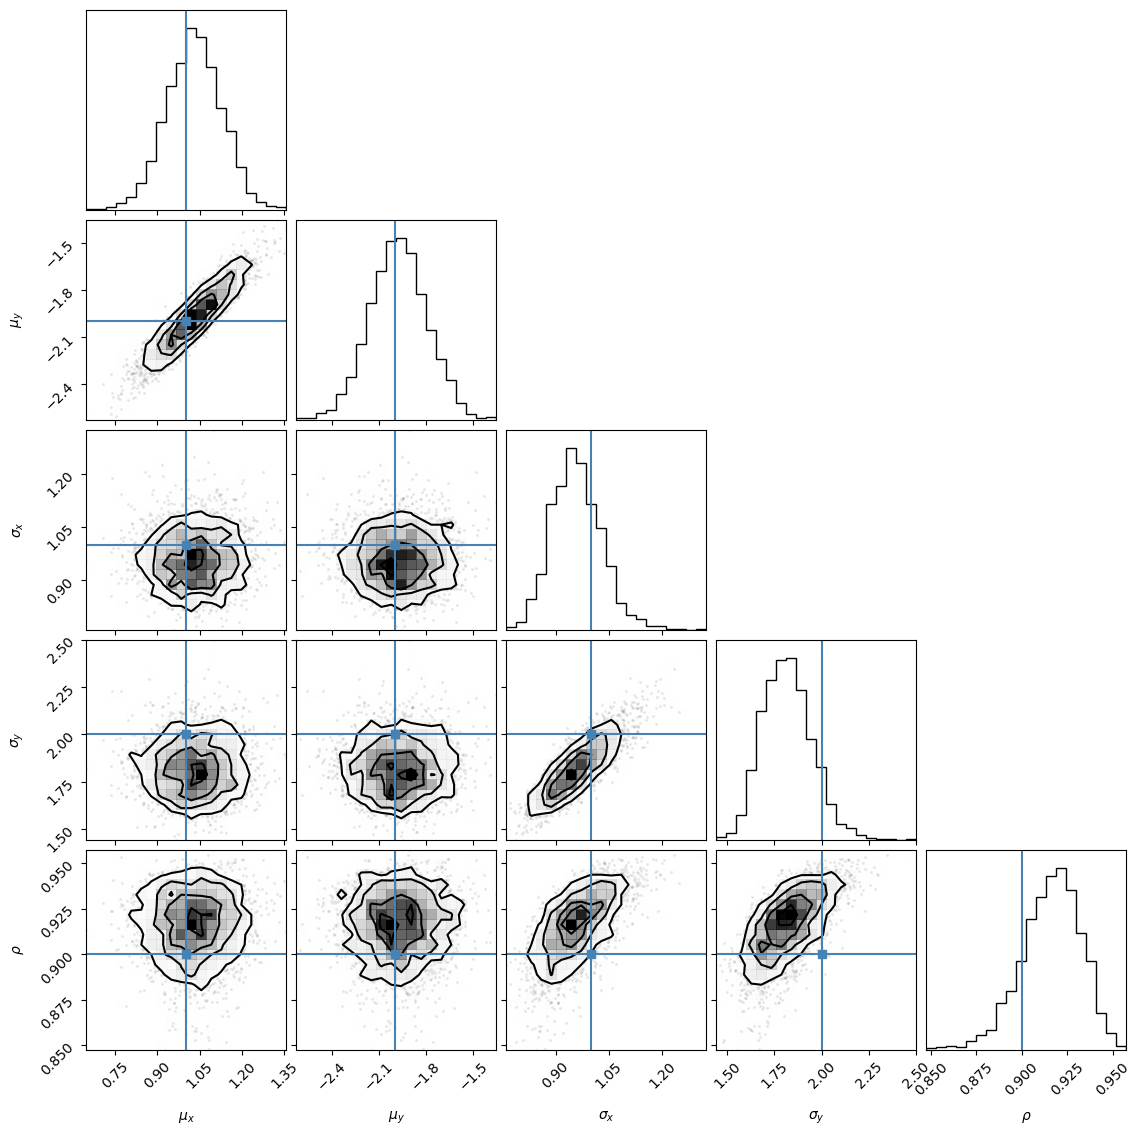

In [13]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=theta);

### Print results

- reporting 16th, 50th, and 84th percentiles, 16-84 range corresonds to $1\sigma$-interval,

In [14]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i].replace("$",""))
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Can we approximate resulting PDF with Gaussian?

#### Estimate approximate Gaussian:

In [15]:
approx_cov = np.cov(flat_samples.T)
approx_mean = np.mean(flat_samples,axis=0)

print("Means vector:")
print(" ".join([f"{v:8.5f}" for v in approx_mean]))

print("Covariance matrix:")
for row in approx_cov:
    print(" ".join([f"{v:8.5f}" for v in row]))  

Means vector:
 1.03084 -1.97405  0.95994  1.82018  0.91608
Covariance matrix:
 0.00951  0.01633  0.00011  0.00025  0.00004
 0.01633  0.03329  0.00004  0.00018  0.00005
 0.00011  0.00004  0.00484  0.00765  0.00072
 0.00025  0.00018  0.00765  0.01716  0.00137
 0.00004  0.00005  0.00072  0.00137  0.00027


#### Generate samples from approximate Gaussian:

In [16]:
rng = np.random.default_rng(seed=42)

samples_from_approximate_gauss = rng.multivariate_normal(approx_mean, 
                                                         approx_cov, 
                                                         size=flat_samples.shape[0])

#### Plot corner plots with samples from posterior (from emcee) and from Gaussian approximation of this posterior

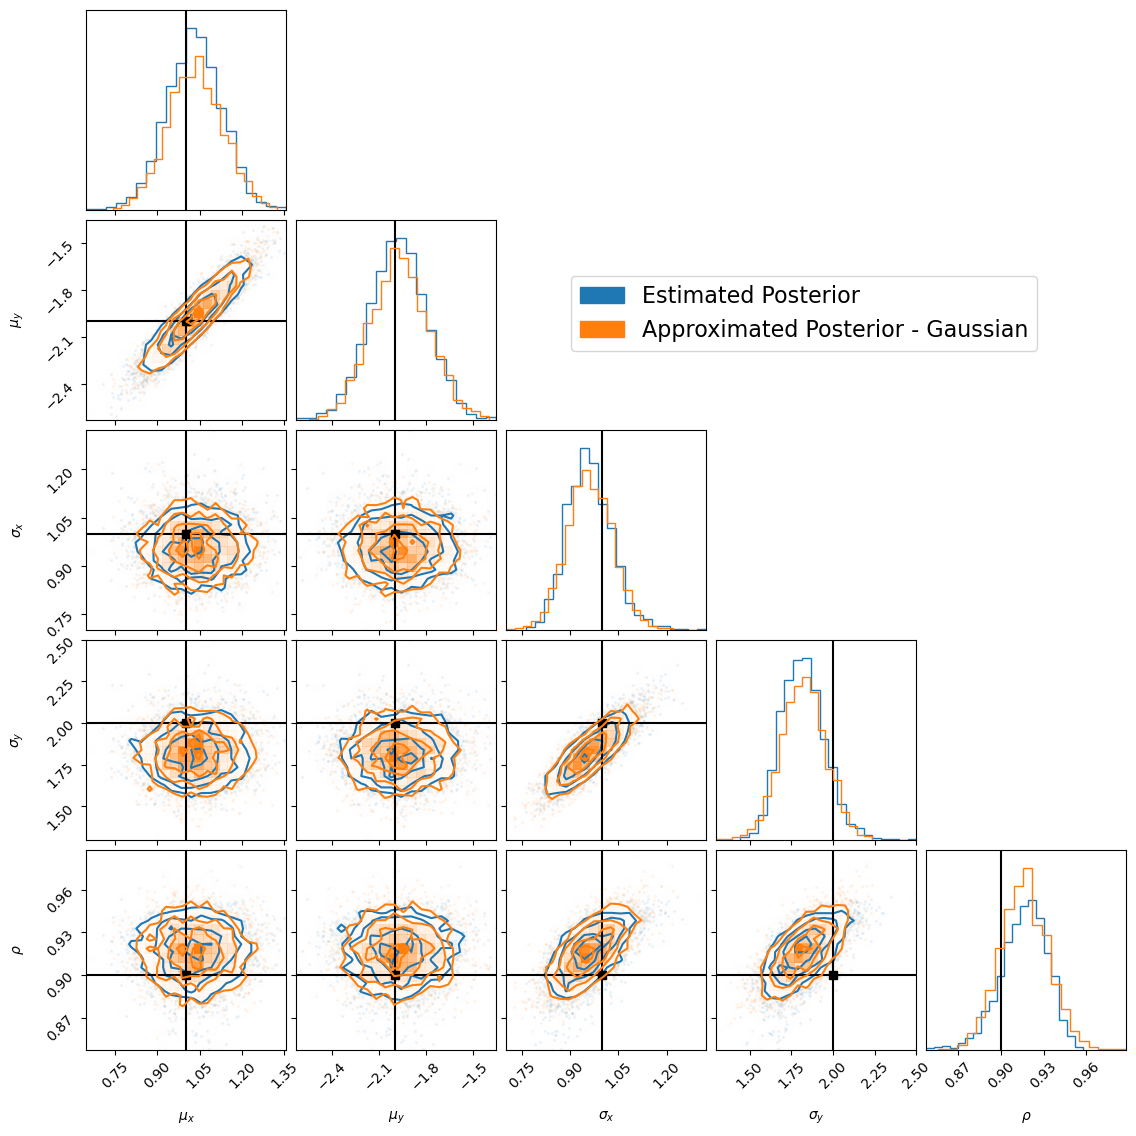

In [17]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig = corner.corner(flat_samples, labels=labels, truths=theta, color="C0", truth_color="black")
corner.corner(samples_from_approximate_gauss, fig=fig, color="C1");

emcee_posterior = mpatches.Patch(color='C0', label='Estimated Posterior')
gaussian_posterior_approx = mpatches.Patch(color='C1', label='Approximated Posterior - Gaussian')
fig.legend(handles=[emcee_posterior, gaussian_posterior_approx], 
           loc='upper right', bbox_to_anchor=(0.9, 0.75),
           fontsize=16)

### Which shows that in this case Gaussian approximation is relatively good!
---

# Scikit learn
Collection of machinea learning algorithms

- https://scikit-learn.org/stable/index.html

In [18]:
# Example below comes from:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

In [19]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

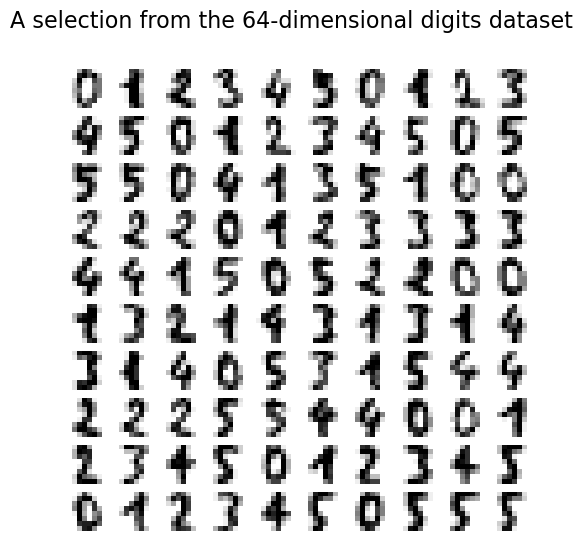

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [21]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

In [22]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(
        n_components=2, n_init=1, max_iter=120, n_jobs=2, normalized_stress="auto"
    ),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embeedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [23]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embeedding...
Computing NCA embedding...


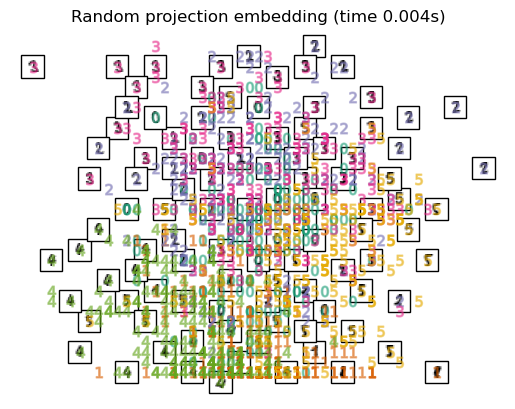

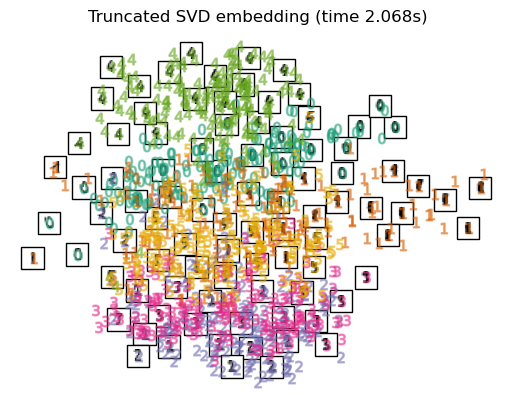

In [ ]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()